In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
import random
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.5.0


## Data

In [3]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# data
tfr_train = '/content/drive/MyDrive/Colab/oxford_pet_tfr/cls_train.tfr'
tfr_valid = '/content/drive/MyDrive/Colab/oxford_pet_tfr/cls_val.tfr'

# class list
cls_file = '/content/drive/MyDrive/Colab/class_list.txt'
class_list = []
with open(cls_file, 'r') as f:
  lines = f.readlines()
  for line in lines:
    line = line.replace('\n','')
    class_list.append(line)

## Classification

In [5]:
IMG_SIZE = 224
N_CLASS = len(class_list)

N_EPOCHS = 50
N_BATCH = 40

learning_rate = 0.0001

N_TRAIN = 6000
N_VAL = 1378
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [6]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    label = tf.cast(parsed_features['cls_num'], tf.int64)
    label = tf.one_hot(label, N_CLASS)   # cutmix를 사용하기 때문에 onehot으로 반환

    return image, label

In [7]:
## CutMix
## 두 개의 이미지를 섞어서 사용
## [1.0, 0.0] or [0.0, 1.0]  --> [0.7, 0.3]

def cutmix(images, labels, PROB=0.5):  
    imgs = []; labs = []
    for i in range(N_BATCH):
        APPLY = tf.cast(tf.random.uniform(()) <= PROB, tf.int32) # cutmix 적용 여부. 확률 0.5
        idx = tf.random.uniform((), 0, N_BATCH, tf.int32)  # i번째 이미지에 idx 번째 이미지를 잘라서 합침

        W = IMG_SIZE; H = IMG_SIZE
        lam = tf.random.uniform(())
        cut_ratio = tf.math.sqrt(1.-lam)    
        cut_w = tf.cast(W * cut_ratio, tf.int32) * APPLY
        cut_h = tf.cast(H * cut_ratio, tf.int32) * APPLY

        # 이미지 가장자리는 선택하지 않도록 center 좌표 조정
        cx = tf.random.uniform((), int(W/8), int(7/8*W), tf.int32)
        cy = tf.random.uniform((), int(H/8), int(7/8*H), tf.int32)

        xmin = tf.clip_by_value(cx - cut_w//2, 0, W)
        ymin = tf.clip_by_value(cy - cut_h//2, 0, H)
        xmax = tf.clip_by_value(cx + cut_w//2, 0, W)
        ymax = tf.clip_by_value(cy + cut_h//2, 0, H)    

        mid_left = images[i, ymin:ymax, :xmin, :]
        mid_mid = images[idx, ymin:ymax, xmin:xmax, :]
        mid_right = images[i, ymin:ymax, xmax:, :]
        middle = tf.concat([mid_left, mid_mid, mid_right], axis=1)
        top = images[i, :ymin, :, :]
        bottom = images[i, ymax:, :, :]
        new_img = tf.concat([top, middle, bottom], axis=0)
        imgs.append(new_img)

        alpha = tf.cast((cut_w*cut_h)/(W*H), tf.float32)
        label1 = labels[i]; label2 = labels[idx]
        new_label = ((1-alpha)*label1 + alpha*label2)
        labs.append(new_label)

    new_imgs = tf.reshape(tf.stack(imgs), [-1, IMG_SIZE, IMG_SIZE, 3])
    new_labs = tf.reshape(tf.stack(labs), [-1, N_CLASS])

    return new_imgs, new_labs

In [8]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH)
# cutmix 적용
train_dataset = train_dataset.map(cutmix).repeat()

In [9]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_valid)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

In [10]:
for image, label in train_dataset.take(1):
    for i in range(N_BATCH):    
        print(label[i].numpy())
        plt.imshow(image[i])
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

### MobileNetV2

In [11]:
from tensorflow.keras import models
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [12]:
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [13]:
def create_mv_model():
    model = models.Sequential()
    model.add(mobilenetv2)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(N_CLASS, activation='softmax'))
    return model

model = create_mv_model()

In [14]:
# learning rate warm-up & exponential decay
# label smoothing

LR_INIT = 0.000001
LR_MAX = 0.0002
LR_MIN = LR_INIT
RAMPUP_EPOCH = 4
EXP_DECAY = 0.9

def lr_schedule_fn(epoch):
    if epoch < RAMPUP_EPOCH:
        lr = (LR_MAX - LR_MIN) / RAMPUP_EPOCH * epoch + LR_INIT
    else:
        lr = (LR_MAX - LR_MIN) * EXP_DECAY**(epoch - RAMPUP_EPOCH)
    return lr

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule_fn)

model.compile(optimizer=tf.keras.optimizers.Adam(LR_INIT),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

# model.summary()

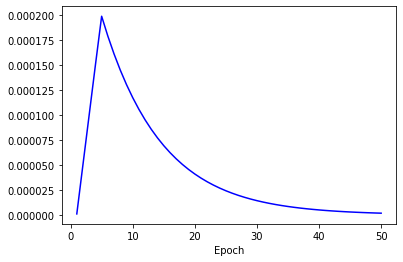

In [15]:
def plot_lr():
    lr = []
    epoch_list = list(np.arange(N_EPOCHS) + 1)
    for epoch in range(N_EPOCHS):
        lr.append(lr_schedule_fn(epoch))    
    plt.plot(epoch_list, lr, 'b-')
    plt.xlabel('Epoch')
    plt.show()

plot_lr()

In [16]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[lr_callback]
)

Epoch 1/50
150/150 [==============================] - 51s 279ms/step - loss: 3.9563 - accuracy: 0.0330 - val_loss: 3.8461 - val_accuracy: 0.0399
Epoch 2/50
150/150 [==============================] - 44s 273ms/step - loss: 2.6589 - accuracy: 0.4255 - val_loss: 1.4335 - val_accuracy: 0.7627
Epoch 3/50
150/150 [==============================] - 44s 277ms/step - loss: 1.8003 - accuracy: 0.7248 - val_loss: 1.1784 - val_accuracy: 0.8382
Epoch 4/50
150/150 [==============================] - 44s 278ms/step - loss: 1.6275 - accuracy: 0.7655 - val_loss: 1.1284 - val_accuracy: 0.8433
Epoch 5/50
150/150 [==============================] - 45s 280ms/step - loss: 1.5104 - accuracy: 0.8102 - val_loss: 1.1378 - val_accuracy: 0.8534
Epoch 6/50
150/150 [==============================] - 45s 283ms/step - loss: 1.4682 - accuracy: 0.8252 - val_loss: 1.1848 - val_accuracy: 0.8411
Epoch 7/50
150/150 [==============================] - 46s 288ms/step - loss: 1.4128 - accuracy: 0.8423 - val_loss: 1.2272 - val_ac

### DenseNet121

In [17]:
from tensorflow.keras.applications.densenet import DenseNet121

In [18]:
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

29089792/29084464 [==============================] - 0s 0us/step


In [20]:
def create_dense_model():
    model = models.Sequential()
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(N_CLASS, activation='softmax'))
    return model

model = create_dense_model()

In [21]:
# learning rate warm-up & exponential decay
# label smoothing

LR_INIT = 0.000001
LR_MAX = 0.0002
LR_MIN = LR_INIT
RAMPUP_EPOCH = 4
EXP_DECAY = 0.9

def lr_schedule_fn(epoch):
    if epoch < RAMPUP_EPOCH:
        lr = (LR_MAX - LR_MIN) / RAMPUP_EPOCH * epoch + LR_INIT
    else:
        lr = (LR_MAX - LR_MIN) * EXP_DECAY**(epoch - RAMPUP_EPOCH)
    return lr

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule_fn)

model.compile(optimizer=tf.keras.optimizers.Adam(LR_INIT),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

# model.summary()

In [22]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[lr_callback]
)

Epoch 1/50
150/150 [==============================] - 91s 497ms/step - loss: 3.9514 - accuracy: 0.0297 - val_loss: 3.8636 - val_accuracy: 0.0348
Epoch 2/50
150/150 [==============================] - 76s 485ms/step - loss: 2.5483 - accuracy: 0.4665 - val_loss: 1.2540 - val_accuracy: 0.8556
Epoch 3/50
150/150 [==============================] - 76s 488ms/step - loss: 1.6938 - accuracy: 0.7622 - val_loss: 1.1193 - val_accuracy: 0.8759
Epoch 4/50
150/150 [==============================] - 77s 495ms/step - loss: 1.5123 - accuracy: 0.8095 - val_loss: 1.0080 - val_accuracy: 0.9115
Epoch 5/50
150/150 [==============================] - 77s 495ms/step - loss: 1.4430 - accuracy: 0.8308 - val_loss: 1.0876 - val_accuracy: 0.8803
Epoch 6/50
150/150 [==============================] - 77s 495ms/step - loss: 1.3979 - accuracy: 0.8450 - val_loss: 1.0560 - val_accuracy: 0.8795
Epoch 7/50
150/150 [==============================] - 77s 494ms/step - loss: 1.3437 - accuracy: 0.8590 - val_loss: 0.9691 - val_ac

## 새로운 Image로 Test하기

In [23]:
## Image upload 후 실행
test_image = '/content/drive/MyDrive/Colab/test_cat.jpg'

image = Image.open(test_image)
image = image.resize((224, 224))
image = np.array(image)
image = image/255.

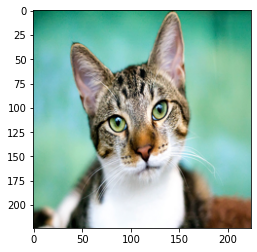

In [24]:
plt.imshow(image)
plt.show()

In [25]:
image = np.reshape(image, (1, 224, 224, 3))

In [26]:
prediction = model.predict(image)
prediction.shape

(1, 37)

In [27]:
pred_class = np.argmax(prediction, axis=-1)
pred_class

array([1])

In [28]:
class_list[int(pred_class)]

'Bengal'